In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import requests
import random
import os
import json
from PIL import Image
import cv2
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
# from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import gc
import torch.nn as nn
from typing import List
from numpy import ndarray
import pdb


In [3]:
%matplotlib inline
from .CFG import CFG # change with your configuration 
                        # file and untrack it in .gitignore for good coding conventions and flexible editing

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
def clean_cuda():
    torch.cuda.empty_cache()
    gc.collect()
clean_cuda()
set_seed(CFG.seed)

# 1. Visualizing one datapoint

In [4]:
# Load the question-answer pairs from the JSON file
with open(CFG.train_json) as f:
    qa_pairs = json.load(f)


In [5]:
qa_pairs[0]
# qa_pairs[0]['image_ids'][0]
# # qa_pairs[0]['responses'][0]['content_en']

{'encounter_id': 'ENC00001',
 'author_id': 'U04473',
 'image_ids': ['IMG_ENC00001_00001.jpg', 'IMG_ENC00001_00002.jpg'],
 'query_title_zh': '胸腔积液伴有皮疹',
 'query_content_zh': '有一胸腔积液患者伴有全身性皮疹见图片（暂发背部图片）',
 'responses': [{'author_id': 'U00217',
   'content_zh': '银屑病，似与胸腔积液没有关系',
   'content_en': 'Psoriasis seems to have no relation to pleural effusion.',
   'content_es': 'La psoriasis parece no tener relación con el derrame pleural.'},
  {'author_id': 'U00214',
   'content_zh': '典型的银屑病',
   'content_en': 'Typical Psoriasis',
   'content_es': 'Psoriasis Típica'},
  {'author_id': 'U00088',
   'content_zh': '银屑病',
   'content_en': 'Psoriasis',
   'content_es': 'Psoriasis'},
  {'author_id': 'U00051',
   'content_zh': '典型的银屑病',
   'content_en': 'Typical Psoriasis',
   'content_es': 'Psoriasis Típica'}],
 'query_title_en': 'Pleural effusion accompanied by rash',
 'query_content_en': 'A patient with pleural effusion is accompanied by a systemic rash, as seen in the picture (currently only the ba

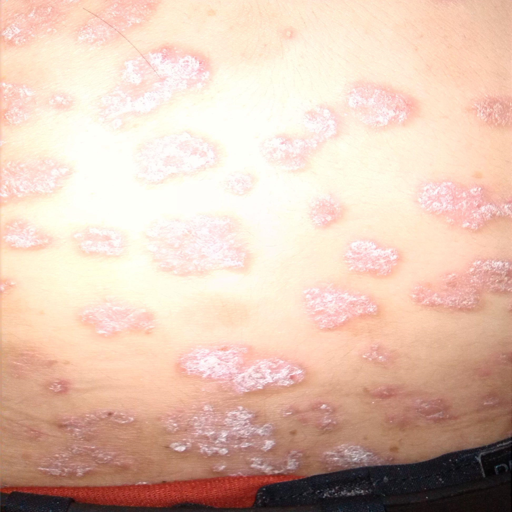

Question: A patient with pleural effusion is accompanied by a systemic rash, as seen in the picture (currently only the back picture is available).
Answer: Psoriasis seems to have no relation to pleural effusion.


In [6]:
len(qa_pairs) # 842 qa pairs
qa_pairs[0]['encounter_id']
img_id = qa_pairs[0]['image_ids'][0] #qa_pairs[0]['image_ids']
image_path = f'{CFG.train_groups}/{img_id}'  # Assuming the image format is .jpg
all_responses = qa_pairs[0]['responses']
# Load the image
image = Image.open(image_path)
one_auth_answer = qa_pairs[0]['responses'][0]['content_en']
# Now, you have the image and its corresponding question-answer pair
# You can process them as needed, for example, display the image and the question-answer

# image.show() # PIL doesn't work
display(image.resize((512, 512)))
print(f"Question: {qa_pairs[0]['query_content_en']}")
print(f"Answer: {one_auth_answer}")

# 2. Building VQA Dataset, DataLoader and checking Eval. Metric

In [7]:
###
# load_image_paths = lambda encounter_id: [os.path.join(CFG.train_groups, img_id) for img_id in encounter_id]
# load_image_paths(qa_pairs[0]['image_ids'])
# qa_pairs[0]['image_ids']
# # load_image_paths = lambda encounter_id: os.path.join(train_dir, encounter_id + '.jpg')
# img_paths = load_image_paths(qa_pairs[0]['image_ids'])
# images = [Image.open(img_path) for img_path in img_paths]
# len(images)

# os.listdir(CFG.train_groups)
# load_questions = lambda qa_pairs: [qa_pairs['query_content_en']] + [qa_pairs['query_content_zh']]
# load_questions(qa_pairs[0])
# load_answers = lambda qa_pairs: [qa_pairs.get(f'responses{i}', None) for i in range(1, 4)]
# load_answers = lambda qa_pairs: [[answer['content_en']] + [answer['content_zh'] + answer['content_es']]  for answer in qa_pairs['responses']]
# load_answers(qa_pairs[0])[0]
# load_encounter_ids = lambda qa_pairs: [qa_pairs['encounter_id']]
# load_encounter_ids(qa_pairs[0])
###
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)  # Ensure loading as RGB image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB if needed
    img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    return img
   
    
class BuildVQADatasetSingleLanguage(torch.utils.data.Dataset):
    '''
    Loading VQA dataset for a single language
    Args:
        json_file - str - directory where train.json file can be found
        train_dir - str - directory where images for training, val and testing are found
        transforms - Albumentations - image transformations defined in CFG file
        train - bool - flag indicating whether to load images, Q&A or only images and questions
        long_answer_ratio - float - number indicating preference for longer answers during bootstrapping
        language - str - indicates which language to load
    Returns:
        encounter_id - str - unique ID for writing into prediction.json file
        images - torch.Tensor - stack of dermatology images
        question - str - unique patient's question
        answers - List[str] - list of answers given by different doctors
        
        encounter_id, images, question, answers if train = True
        encounter_id, images, question if train = False

    '''
    def __init__(self,json_file='/kaggle/input/mediqa-m3g/mediqa-m3-clinicalnlp2024/train.json', train_dir='/kaggle/input/mediqa-m3g/images_final/images_train', 
                 transforms=None, train=True, long_answer_ratio = 0.7, language = 'content_en'):
        with open(json_file) as f:
            self.qa_pairs = json.load(f)
        self.transforms = transforms
        self.train_dir = train_dir
        self.load_encounter_id = lambda qa_pairs: qa_pairs['encounter_id']
        self.load_image_paths = lambda encounter_id: [os.path.join(self.train_dir, img_id) for img_id in encounter_id]
        self.load_questions = lambda qa_pairs: qa_pairs[f'query_{language}']
        self.train = train
        self.load_answers = lambda qa_pairs: [answer[f'{language}'] for answer in qa_pairs['responses']] if self.train else None
        self.long_answer_ratio = long_answer_ratio # for bootstrapping longer answers
        self.language = language
    def __len__(self):
        return len(self.qa_pairs)
    
    def __getitem__(self, index):
        qa_pair = self.qa_pairs[index]

        img_paths = self.load_image_paths(qa_pair['image_ids'])
        images = [load_img(img_path)  for img_path in img_paths]
        question: str = self.load_questions(qa_pair)
        answers: List[str] = self.load_answers(qa_pair) if self.train else None
        encounter_id: str = self.load_encounter_id(qa_pair)
        
        if self.train:
            if self.transforms:
                images = [self.transforms(image=image) for image in images] # at least resizes them
                images  = torch.stack([torch.tensor(image['image']) for image in images])  # list of tensors
            else:
                images  =  torch.stack([torch.tensor(image) for image in images])
            
            if len(images) < len(answers):
                # bootstrap images to the same size as answers
                sampled_img_indices: ndarray = np.random.choice(len(images), len(answers) - len(images))
                #pdb.set_trace()
                sampled_images: torch.Tensor = images[sampled_img_indices]
                sampled_images_augmented: torch.Tensor = torch.vstack([images, sampled_images])
                return (encounter_id, self.language), sampled_images_augmented, question, answers  
            elif len(answers) < len(images):
                # bootstrap answers
                remaining_answers = len(images) - len(answers)

                # Fill the remaining entries with random samples, preferring longer strings
                additional_answers = []
                for _ in range(remaining_answers):
                    if random.random() < self.long_answer_ratio:  # Adjust preference for longer strings as needed
                        sampled_answer = max(answers, key=len)  # Sample from existing answers based on length
                    else:
                        sampled_answer = random.choice(answers)  # Randomly sample from existing answers
                    additional_answers.append(sampled_answer)

                # Combine existing and additional answers
                expanded_answers = answers + additional_answers
                return (encounter_id, self.language), images, question, expanded_answers
            else:
                assert len(images) == len(answers)
                return (encounter_id, self.language), images, question, answers
            
        else:   # validation/testing
            if self.transforms:
                images = [self.transforms(image=image) for image in images]
                images  = torch.stack([torch.tensor(image['image']) for image in images])  # list of tensors
            else:
                images  =  torch.stack([torch.tensor(image) for image in images])

            return (encounter_id, self.language), images, question

In [8]:
class BuildVQADatasetMultilingual(torch.utils.data.Dataset):
    '''
    Loading VQA dataset for multiple languages
    Args:
        json_file - str - directory where train.json file can be found
        train_dir - str - directory where images for training, val and testing are found
        transforms - Albumentations - image transformations defined in CFG file
        train - bool - flag indicating whether to load images, Q&A or only images and questions
        long_answer_ratio - float - number indicating preference for longer answers during bootstrapping
        
    Returns:
        encounter_id - str - unique ID for writing into prediction.json file
        images - torch.Tensor - stack of dermatology images
        question - str - unique patient's question
        answers - List[str] - list of answers given by different doctors
        
        encounter_id, images, question, answers if train = True
        encounter_id, images, question if train = False

    '''
    def __init__(self, json_file='/kaggle/input/mediqa-m3g/mediqa-m3-clinicalnlp2024/train.json', 
                 train_dir='/kaggle/input/mediqa-m3g/images_final/images_train', 
                 transforms=None, train=True, long_answer_ratio=0.7):
        with open(json_file) as f:
            self.qa_pairs = json.load(f)
        self.load_encounter_id = lambda qa_pairs: qa_pairs['encounter_id']
        self.transforms = transforms
        self.train_dir = train_dir
        self.train = train
        self.long_answer_ratio = long_answer_ratio
        self.total_patients = len(self.qa_pairs)
        
    def load_image_paths(self, encounter_id):
        return [os.path.join(self.train_dir, img_id) for img_id in encounter_id]
    
    def load_questions(self, qa_pairs, language):
        return qa_pairs[f'query_content_{language}']
    
    def load_answers(self, qa_pairs, language):
        if self.train:
            return [answer[f'content_{language}'].replace('\n', '') for answer in qa_pairs['responses']]
        else:
            return None
    
    def __len__(self):
        return self.total_patients * 3  # English, Chinese, and Spanish
    
    def __getitem__(self, index):
        # Determine the language based on the index
        if index < self.total_patients:
            language = 'en'
        elif index < self.total_patients * 2:
            language = 'zh'
            index -= self.total_patients  # Adjust index for Chinese
        else:
            language = 'es'
            index -= self.total_patients * 2  # Adjust index for Spanish
        
        qa_pair = self.qa_pairs[index]
        img_paths = self.load_image_paths(qa_pair['image_ids'])
        images = [load_img(img_path) for img_path in img_paths]
        question: str = self.load_questions(qa_pair, language)
        answers: List[str] = self.load_answers(qa_pair, language) if self.train else None
        encounter_id: str = self.load_encounter_id(qa_pair)

        if self.train:
            if self.transforms:
                images = [self.transforms(image=image) for image in images] # at least resizes them
                images  = torch.stack([torch.tensor(image['image']) for image in images])  # list of tensors
            else:
                images  =  torch.stack([torch.tensor(image) for image in images])
            
            if len(images) < len(answers):
                # bootstrap images to the same size as answers
                sampled_img_indices: ndarray = np.random.choice(len(images), len(answers) - len(images))
                #pdb.set_trace()
                sampled_images: torch.Tensor = images[sampled_img_indices]
                sampled_images_augmented: torch.Tensor = torch.vstack([images, sampled_images])
                return (encounter_id, f'content_{language}'), sampled_images_augmented, question, answers  
            elif len(answers) < len(images):
                # bootstrap answers
                remaining_answers = len(images) - len(answers)

                # Fill the remaining entries with random samples, preferring longer strings
                additional_answers = []
                for _ in range(remaining_answers):
                    if random.random() < self.long_answer_ratio:  # Adjust preference for longer strings as needed
                        sampled_answer = max(answers, key=len)  # Sample from existing answers based on length
                    else:
                        sampled_answer = random.choice(answers)  # Randomly sample from existing answers
                    additional_answers.append(sampled_answer)

                # Combine existing and additional answers
                expanded_answers = answers + additional_answers
                return (encounter_id, f'content_{language}'), images, question, expanded_answers
            else:
                assert len(images) == len(answers)
                return (encounter_id, f'content_{language}'), images, question, answers
            
        else:   # validation/testing
            if self.transforms:
                images = [self.transforms(image=image) for image in images]
                images  = torch.stack([torch.tensor(image['image']) for image in images])  # list of tensors
            else:
                images  =  torch.stack([torch.tensor(image) for image in images])

            return (encounter_id, f'content_{language}'), images, question

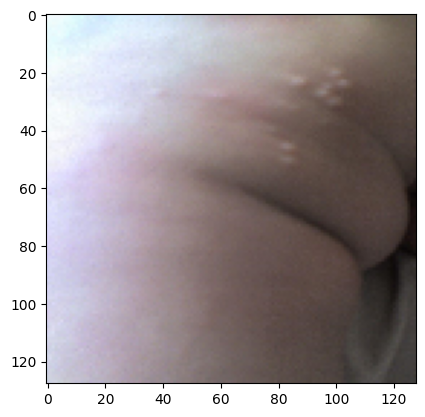

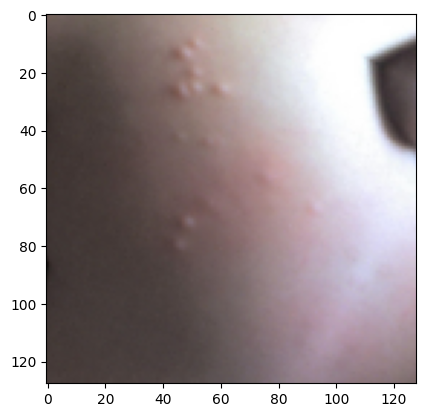

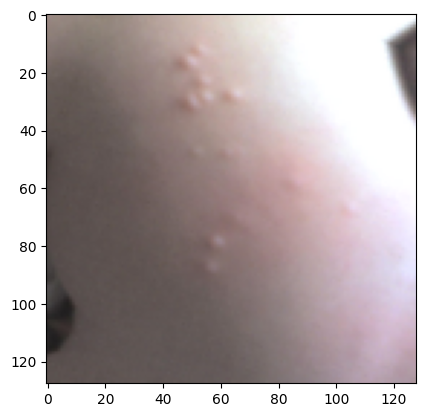

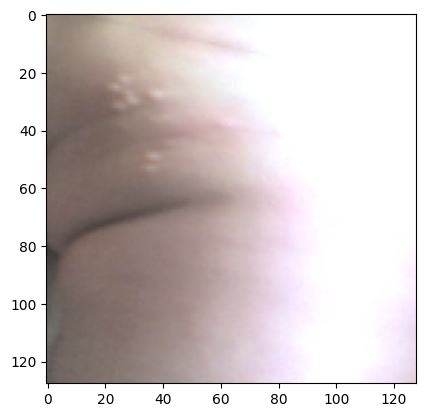

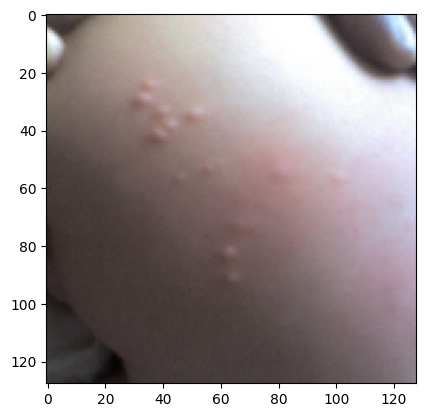

question:  Un bebé de siete meses desarrolló estos bultos en el lado exterior de la pierna derecha hace tres días.
El médico dijo que fue causado por el clima cálido y húmedo.
Información adicional: La foto fue tomada con un teléfono móvil. Parece que no le pica, los bultos son blancos, no rojos, y tienen un poco de brillo perlado. También no hay líquido dentro.
answer  ['¡Demasiado vago!Existe una alta posibilidad de verrugas blandas infecciosas.', '', 'No me parece que sea molusco contagioso.', 'El lugar común para las verrugas infecciosas no es en el muslo.', 'Herpes Simplex']
2526  total training images 


In [9]:

train_dir = CFG.train_groups
train_img_paths = list(map(lambda x: os.path.join(train_dir, x), os.listdir(train_dir)))
train_dataset_multi = BuildVQADatasetMultilingual(transforms=CFG.data_transforms['train'], 
                                json_file=CFG.train_json,
                                train_dir=CFG.train_groups)
idx = 2500
for i in range(train_dataset_multi[idx][1].shape[0]):
    plt.imshow(train_dataset_multi[idx][1][i, :, :, :].numpy())
    plt.show()
print('question: ', train_dataset_multi[idx][2])
print('answer ', train_dataset_multi[idx][3])
print(len(train_dataset_multi), ' total training images ')



## 2.1 Checking training data

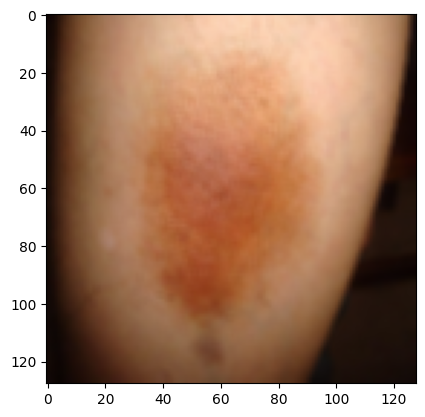

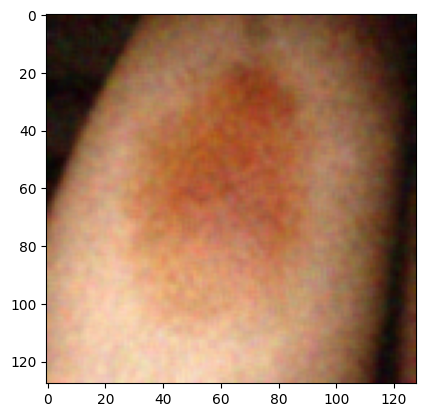

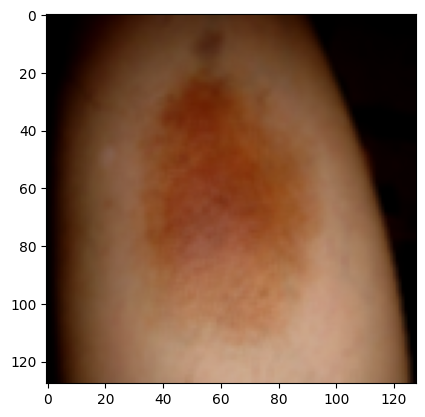

['Golden lichen is a type of pigment purpuric skin disease.', 'Golden Yellow Lichen?', 'Pathology.']
['金黄色苔藓，属于色素性紫癜性皮肤病的一种', '金黄色苔藓？', '病理吧，，，']
['El liquen dorado es un tipo de enfermedad de la piel pigmentada púrpura.', '¿Liquen Dorado Amarillo?', 'Patología.']


In [10]:

train_dir = CFG.train_groups

train_img_paths = list(map(lambda x: os.path.join(train_dir, x), os.listdir(train_dir)))
train_dataset = BuildVQADatasetSingleLanguage(transforms=CFG.data_transforms['train'], 
                                json_file = CFG.train_json,
                                train_dir = CFG.train_groups,
                                language = 'content_en')
train_dataset_zh = BuildVQADatasetSingleLanguage(transforms=CFG.data_transforms['train'], 
                                json_file=CFG.train_json,
                                train_dir=CFG.train_groups,
                                language = 'content_zh')
train_dataset_es = BuildVQADatasetSingleLanguage(transforms=CFG.data_transforms['train'], 
                                json_file=CFG.train_json,
                                train_dir=CFG.train_groups,
                                language = 'content_es')
idx = 42
for i in range(train_dataset[idx][1].shape[0]):
    plt.imshow(train_dataset[idx][1][i, :, :, :].numpy())
    plt.show()
print(train_dataset[idx][3])
print(train_dataset_zh[idx][3])
print(train_dataset_es[idx][3])

## 2.2 Checking validation data

Question: What are the red lumps on my back?  It grows in summer and goes away in winter.  What kinds of drugs can be used for this?
Question: 背部红颗是什么？一到夏天就长红颗冬天没有，这个用什么药物
Question: ¿Qué son los bultos rojos que tengo en la espalda?  Crecen en verano y desaparecen en invierno.  ¿Qué tipo de medicamentos se pueden utilizar para esto?
168 Question: What are the red lumps on my back?  It grows in summer and goes away in winter.  What kinds of drugs can be used for this?


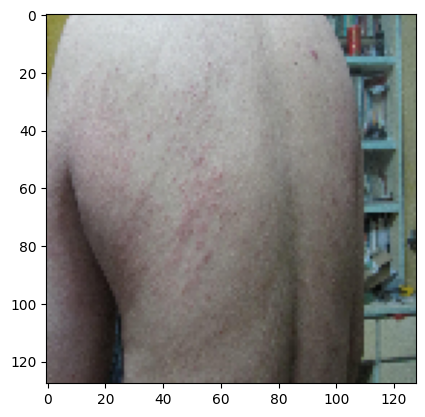

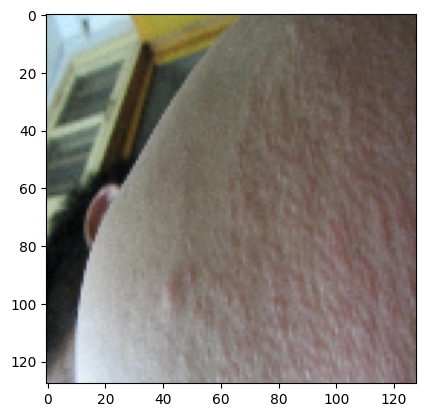

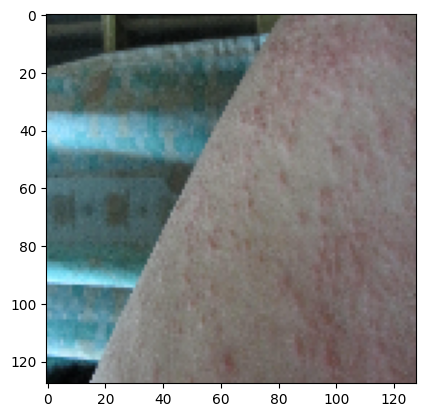

In [11]:
val_dir = CFG.valid_groups

val_img_paths = list(map(lambda x: os.path.join(val_dir, x), os.listdir(val_dir)))
val_dataset = BuildVQADatasetSingleLanguage(transforms=CFG.data_transforms['valid'], 
                                json_file=CFG.valid_json,
                                train_dir=CFG.valid_groups, train=False,
                                language='content_en')
val_dataset_zh = BuildVQADatasetSingleLanguage(transforms=CFG.data_transforms['valid'], 
                                json_file=CFG.valid_json,
                                train_dir=CFG.valid_groups, train=False,
                                language='content_zh')
val_dataset_es = BuildVQADatasetSingleLanguage(transforms=CFG.data_transforms['valid'], 
                                json_file=CFG.valid_json,
                                train_dir=CFG.valid_groups, train=False,
                                language='content_es')
val_dataset_multi = BuildVQADatasetMultilingual(transforms=CFG.data_transforms['valid'], 
                                json_file=CFG.valid_json,
                                train_dir=CFG.valid_groups, train=False,
                                )
idx = 36
print(f"Question: {val_dataset[idx][2]}")
print(f"Question: {val_dataset_zh[idx][2]}")
print(f"Question: {val_dataset_es[idx][2]}")
print(len(val_dataset_multi), f"Question: {val_dataset_multi[idx][2]}")


for i in range((val_dataset[idx][1].shape[0])):
    plt.imshow(val_dataset[idx][1][i])
    plt.show()

# 3. Building Dataloader

In [12]:

train_dataloader = DataLoader(train_dataset,
                              # collate_fn=custom_collate_fn,
                              batch_size=CFG.train_bs,
                              shuffle=True)
val_dataloader = DataLoader(val_dataset,
                            # collate_fn=collate_fn,
                            batch_size=CFG.valid_bs,
                            shuffle=False)

In [13]:
batch = next(iter(train_dataloader))
len(batch) # each datapoint is (encounter_id, img, q, a)

4

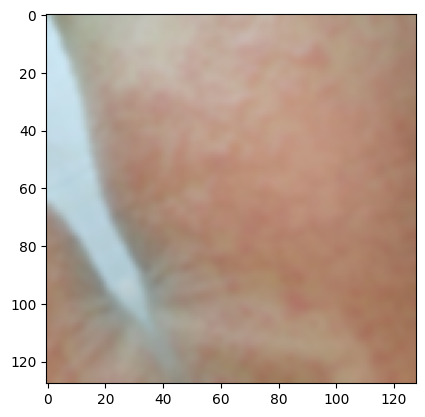

In [14]:
plt.imshow(batch[1][0][0]) # when batch size is 1, this is the first question

# 4. Exploring sacrebleu validation scoring

In [15]:
from deltableu import *
score = get_deltableu_score('prediction_test.json', reference_dir='mediqa-m3g-startingkit-v2/app/input/ref/reference_test.json')
score 

Checking BLEU
BLEU = 76.96 85.9/81.0/80.1/81.8 (BP = 0.937 ratio = 0.939 hyp_len = 46 ref_len = 49)
BLEU = 84.65 100.0/100.0/100.0/100.0 (BP = 0.846 ratio = 0.857 hyp_len = 12 ref_len = 14)
BLEU = 94.58 95.9/94.5/94.2/93.8 (BP = 1.000 ratio = 1.000 hyp_len = 36 ref_len = 36)
{'deltableu_es': 76.96417591583543, 'deltableu_zh': 84.64817248906144, 'deltableu_en': 94.57546464719972}


85.3959376840322

# 5. Building baseline with BLIP

In [16]:
# model
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")# .to(CFG.device)
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")# .to(CFG.device)
blip_config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")


## 5.1 Testing the image and text encoders

In [17]:
train_dataset[0][3]

['Psoriasis seems to have no relation to pleural effusion.',
 'Typical Psoriasis',
 'Psoriasis',
 'Typical Psoriasis']

In [18]:
# batch[2][0]
text = train_dataset_es[0][3]
encoding = text_processor(None,
                          text,
                          padding="max_length",
                          truncation=True,
                          max_length = 32,
                          return_tensors="pt")

encoding['input_ids']

tensor([[  101,  2474,  8827, 11069,  6190, 11968, 26005,  2053,  2702,  2121,
          2128,  2721, 10446,  9530,  3449,  4315,  6444,  2063, 20228, 11236,
          2389,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  8827, 11069,  6190,  5955,  5555,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  8827, 11069,  6190,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  101,  8827, 11069,  6190,  5955,  5555,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,  

In [19]:
img = train_dataset[0][1] 
image_encoding = image_processor(img,
                                 do_rescale=False,
                                 #size=(self.image_height,self.image_width),
                                 return_tensors="pt")


In [20]:
class EncodedVQADataset(torch.utils.data.Dataset):
    def __init__(self, dataset, text_processor, image_processor, train=True):
        self.dataset = dataset
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.train = train

        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # get image + text
        answers = self.dataset[idx][3] if self.train else None
        questions = self.dataset[idx][2]
        images = self.dataset[idx][1]#.convert('RGB')
        # text = self.questions[idx]
        encounter_id = self.dataset[idx][0]

        image_encoding = self.image_processor(images,
                                  do_rescale=False,
                                  # size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  questions,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )

        encoding["pixel_values"] = image_encoding["pixel_values"].to(CFG.device)# [0]
        
        
        labels = [self.text_processor.tokenizer.encode(
                  answer,
                  max_length=self.max_length,
                  padding="max_length",
                  truncation=True,
                  return_tensors='pt')[0].to(CFG.device) for answer in answers] if self.train else None
        if self.train:
            encoding["labels"] = torch.stack(labels)# .to(CFG.device)

        return encounter_id, encoding
 

## 5.2 Encoding training set

In [21]:

encoded_train_dataset = EncodedVQADataset(train_dataset, 
                                          text_processor = text_processor, 
                                          image_processor = image_processor)


encoded_train_dataset_multi = EncodedVQADataset(train_dataset_multi, 
                                          text_processor = text_processor, 
                                          image_processor = image_processor)


In [22]:
encoded_train_dataset_multi[0][0]

('ENC00001', 'content_en')

In [23]:
tst = encoded_train_dataset_multi[1234]
for ans in tst[1]['labels']:
    print(text_processor.decode(ans))

[CLS] [UNK] 子 ， [UNK] [UNK] 大 [UNK] [UNK] ， [UNK] [UNK] [UNK] [UNK] [UNK] 的 外 [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] ， [UNK] [UNK] 不 大 [SEP] [PAD] [PAD] [PAD]
[CLS] [UNK] [UNK] [UNK] 。 。 。 。 。 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] [UNK] ， 外 [UNK] [UNK] 生 [UNK] [UNK] [UNK] [UNK] [UNK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] 火 [UNK] 子 ， 火 [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] 。 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] [UNK] [UNK] [UNK] 外 [UNK] ， 有 [UNK] [UNK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## 5.3 Encoding validation set (no labels)

In [24]:
encoded_val_dataset = EncodedVQADataset(val_dataset, 
                                        text_processor = text_processor, 
                                        image_processor = image_processor,
                                        train=False)

encoded_val_dataset_multi = EncodedVQADataset(val_dataset_multi, 
                                        text_processor = text_processor, 
                                        image_processor = image_processor,
                                        train=False)

tst = encoded_val_dataset_multi[100 - 1]
for ans in tst[1]['input_ids']:
    print(text_processor.decode(ans))

[CLS] [UNK] [UNK] 家 [UNK] [UNK] [UNK] [UNK] ， [UNK] 一 家 [UNK] 主 [UNK] [UNK] [UNK] [UNK] [UNK] 真 [UNK] [UNK] [UNK] ， [UNK] 二 家 [UNK] [UNK] [UNK] [UNK] [SEP]


In [25]:
encoded_train_dataset[7][1]['labels'].device
encoded_train_dataset[7][1]['input_ids'].device
print(encoded_train_dataset[0][1]['pixel_values'].shape)
# print(encoded_train_dataset[1]['pixel_values'].shape)
print(encoded_train_dataset[0][1]['labels'].shape)
# print(encoded_train_dataset[1]['labels'].shape)
print(train_dataset[0][2])

torch.Size([4, 3, 384, 384])
torch.Size([4, 32])
A patient with pleural effusion is accompanied by a systemic rash, as seen in the picture (currently only the back picture is available).


In [26]:
print(encoded_val_dataset[0][1]['pixel_values'].shape)
print(encoded_val_dataset[4][1]['pixel_values'].shape)
print(encoded_val_dataset[0][0]) # index 0, tuple idx 0 which is encounter id 

torch.Size([2, 3, 384, 384])
torch.Size([1, 3, 384, 384])
('ENC00852', 'content_en')


In [27]:
def custom_encode_collate_fn(batch):
    '''
    this creates a list of dicts
    '''
    # Initialize lists to store batch components
    batch_dicts = []
    

    for item in batch:
        batch_dicts.append(item)

    # Return a dictionary with the same structure as the individual items
    return batch_dicts



In [28]:
encoded_train_dataset[0][1].keys() # idx 0, 1 for encoding

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'labels'])

# 6. Building training and validation loaders for encoded dataset

In [37]:

encoded_train_dataloader = DataLoader(encoded_train_dataset,
                              collate_fn=custom_encode_collate_fn, # comment this out if bs is 1
                              batch_size=CFG.train_bs,
                              shuffle=True)

encoded_train_dataloader_multi = DataLoader(encoded_train_dataset_multi,
                              collate_fn=custom_encode_collate_fn, # comment this out if bs is 1
                              batch_size=CFG.train_bs,
                              shuffle=True)

encoded_val_dataloader = DataLoader(encoded_val_dataset,
                              collate_fn=custom_encode_collate_fn, # comment this out if bs is 1
                              batch_size=CFG.valid_bs,
                              shuffle=False)


encoded_val_dataloader_multi = DataLoader(encoded_val_dataset_multi,
                              collate_fn=custom_encode_collate_fn, # comment this out if bs is 1
                              batch_size=CFG.valid_bs,
                              shuffle=False)

In [38]:
fst_batch = next(iter(encoded_train_dataloader))
fst_batch_val = next(iter(encoded_val_dataloader))


In [41]:
# model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" ).to(CFG.device)

class BatchModel(nn.Module):
    'matched with the loader of a list of dicts, not single img with single ans'
    def __init__(
        self, train=True
    ):
        super().__init__()
        self.model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" ).to(CFG.device)
        self.train = train
    def forward(self, batch):
        
        
        outputs = [0] * len(batch)
        if self.train:

            for i in range(len(batch)):

                outputs[i] = self.model(**batch[i])
                # pdb.set_trace()
        else:
            for i in range(len(batch)):
                outputs[i] = self.model.generate(**batch[i][1])
        
        return outputs
    
batch_model = BatchModel()

In [42]:
# outputs = batch_model(fst_batch)
clean_cuda()
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" ).to(CFG.device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# image_mean = image_processor.image_mean
# image_std = image_processor.image_std


In [43]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

384672572

In [44]:
batch_model.train=False
output = batch_model(fst_batch_val)

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [35]:
for answer in output:
    print("Predicted Answer: ",[text_processor.decode(each_answer,skip_special_tokens=True) for each_answer in answer])


Predicted Answer:  ['yes']


# 7. Evaluating BLIP with Sacrebleu

In [69]:
batch_model.train = True
for epoch in range(CFG.epochs):
    print(f"Epoch: {epoch}")
    total_loss = []
    for batch in tqdm(encoded_train_dataloader):

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = batch_model(batch)
        # pdb.set_trace()
        loss = outputs[0].loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        clean_cuda()
    print("Loss:", sum(total_loss))

In [67]:
def get_existing_encounter_idx(output, encounter_id):
    for i in range(len(output)):
        if output[i]['encounter_id'] == encounter_id:
            return i
output = []
existing_encounter_ids = []
for val_batch in encoded_val_dataloader_multi:
    encounter_id = val_batch[0][0][0]
    predictions = batch_model(val_batch)
    if not (encounter_id in existing_encounter_ids):
        output.append({
            "encounter_id": encounter_id,
            "responses": [{} for _ in range(predictions[0].shape[0])]
        })
    existing_encounter_ids.append(encounter_id)
    # pdb.set_trace()
    encounter_idx = get_existing_encounter_idx(output = output, encounter_id = encounter_id)
    for idx, answer in enumerate(predictions[0]): # assuming single batch
        
        output[encounter_idx]["responses"][idx][val_batch[0][0][1]] = \
        text_processor.decode(answer ,skip_special_tokens=True)
    # pdb.set_trace()
output_json = json.dumps(output, indent=4)
with open("output.json", "w") as f:
    f.write(output_json)

In [68]:
score = get_deltableu_score('output.json', reference_dir='mediqa-m3g-startingkit-v2/app/input/ref/reference.json')
score 

BLEU = 0.00 13.2/8.5/0.0/0.0 (BP = 0.052 ratio = 0.253 hyp_len = 63 ref_len = 249)
BLEU = 0.00 0.5/0.5/0.9/0.0 (BP = 0.094 ratio = 0.298 hyp_len = 111 ref_len = 373)
BLEU = 0.00 1.0/8.9/12.5/0.0 (BP = 0.037 ratio = 0.232 hyp_len = 59 ref_len = 254)
{'deltableu_es': 0.0, 'deltableu_zh': 0.0, 'deltableu_en': 0.0}


0.0